In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn import svm
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
import bovo.svm as bsvm

In [49]:
# loading the data

x_df, target_values = bsvm.load_data("PSurfMand")
loss_threshold = 14
y_df = [0 if x < loss_threshold/100 else 1 for x in target_values]
print("minimum expected accuracy : ", max(np.mean(y_df), 1-np.mean(y_df)))

x_data = x_df.to_numpy()
y_data = np.array(y_df)
# print(y_df)


minimum expected accuracy :  0.5076923076923077


In [5]:
x = (x_data-np.mean(x_data, axis=0, keepdims=True))/(np.var(x_data, axis=0, keepdims=True)+1e-3)
y = y_data
print(x.shape)

(195, 42)


In [47]:


if False: # sbf kernel
    pass
    # C_range = np.logspace(-2, 5, 12)
    # gamma_range = np.logspace(-5, 2, 12)

    # C_range = np.logspace(1, 3.5, 10*2)
    # gamma_range = np.logspace(-0.2, 0.8, 10*2)

    # C_range = np.logspace(2.5, 3.2, 10*2)
    # gamma_range = np.logspace(0, 0.3, 10*2)

    # C_range = np.logspace(2.7, 3, 10*2)
    # gamma_range = np.logspace(0.15, 0.25, 10*2)
    
    #param_grid = dict(gamma=gamma_range, C=C_range)

if True:
    C_range = np.logspace(-4, 0.5, 128)

    # C_range = np.logspace(3, 4, 12)
    # gamma_range = np.logspace(-5, -4, 12)

    param_grid = dict(C=C_range)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(kernel="linear"), param_grid=param_grid, cv=cv)

start_time = time.time()

grid.fit(x, y_data)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)
end_time = time.time()
print("grid search time :", end_time-start_time)

The best parameters are {'C': 0.0036228897509242896} with a score of 0.65
grid search time : 22.98686385154724


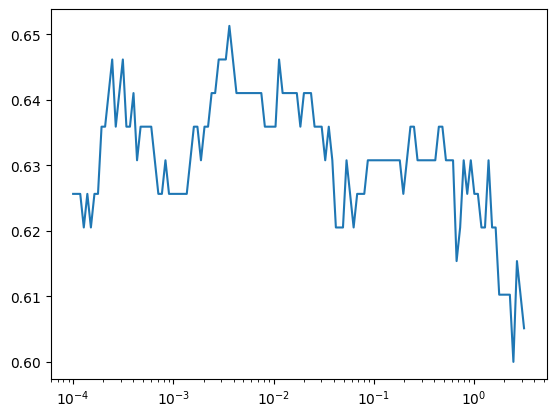

In [48]:

plt.plot(C_range, grid.cv_results_["mean_test_score"])
plt.xscale("log")

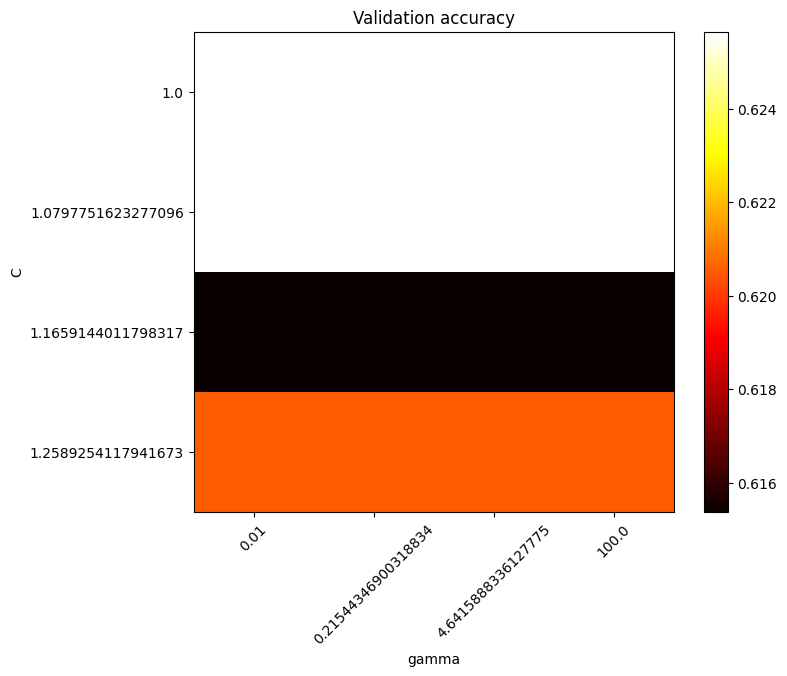

In [31]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()


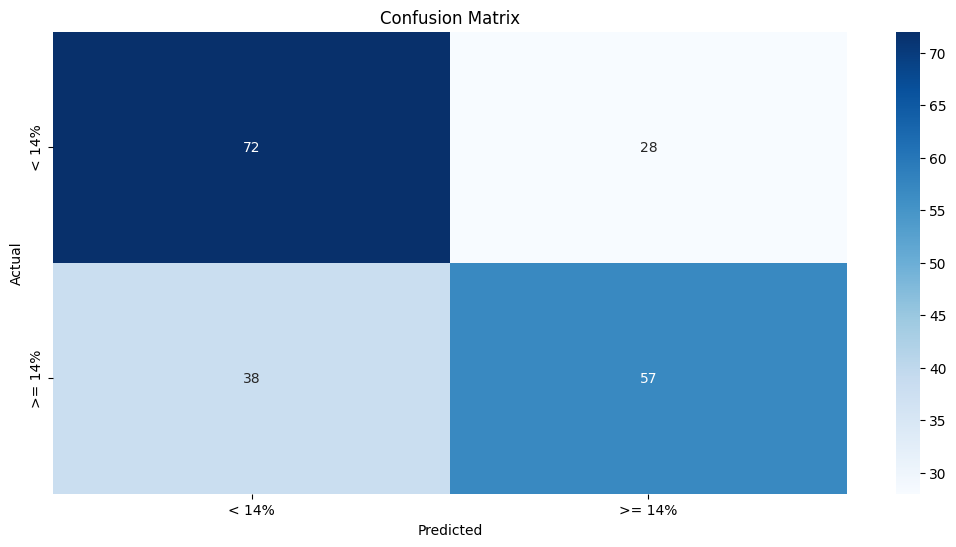

In [9]:
actual_classes = []
predicted_classes = []

for train_index, test_index in cv.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = svm.SVC(C = grid.best_params_["C"], gamma=grid.best_params_["gamma"])
    _ = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    actual_classes = actual_classes + list(y_test)
    predicted_classes = predicted_classes + list(y_pred)

sorted_labels = ["< {}%".format(loss_threshold), ">= {}%".format(loss_threshold)]
matrix = confusion_matrix(actual_classes, predicted_classes)
    
plt.figure(figsize=(12.8,6))
sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

plt.show()